Pourcentage de 0 par étude (en %):
FairPARKII    12.0
PULSE         12.9
PREDISTIM     28.0
dtype: float64


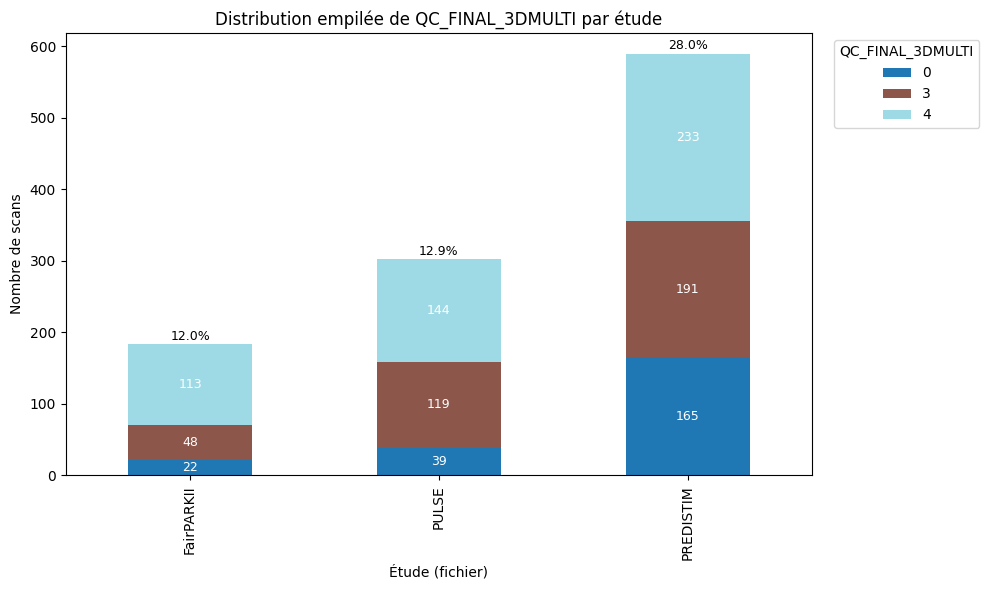

In [104]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

paths = [
    Path("/NAS/dumbo/protocoles/FAIRPARKII/FairparkII_MRIData_20210622.xlsx"),
    Path("/NAS/tupac/protocoles/PULSE/data/20240212-164053__PourRV_stage2024/MRIDATA_Pulse_3DT1_3DMULTIGRE_20240212.xlsx"),
    Path("/NAS/deathrow/protocoles/predistim/csv_xlsx/Predistim_MRIdata_v20200406_update20201204.xlsx"),
]

def short_study_name(stem: str) -> str:
    s = stem.lower()
    if "fair" in s or "fairpark" in s:
        return "FairPARKII"
    if "pulse" in s:
        return "PULSE"
    if "predistim" in s or "pred" in s:
        return "PREDISTIM"
    return stem

counts_by_study = {}
for p in paths:
    if not p.exists():
        print(f"Fichier introuvable, saut: {p}")
        continue
    # lire toutes les feuilles et concat si besoin
    sheets = pd.read_excel(p, sheet_name=None, header=1, engine="openpyxl")
    if len(sheets) == 1:
        df_local = next(iter(sheets.values()))
    else:
        try:
            df_local = pd.concat(sheets.values(), ignore_index=True, sort=False)
        except Exception:
            df_local = next(iter(sheets.values()))
    df_local.columns = df_local.columns.str.strip()
    col = "QC_FINAL_3DMULTI"
    if col not in df_local.columns:
        print(f"Colonne {col} introuvable dans {p.name}, saut.")
        continue

    s = df_local[col]
    # retirer NaN et valeurs "NF" (insensible à la casse)
    mask = s.notna() & (s.astype(str).str.upper() != "NF")
    s = s[mask]
    # convertir en numérique si possible (pour regrouper 0.0 / 3.0 / 4.0, etc.)
    s = pd.to_numeric(s, errors="coerce").dropna()
    counts = s.value_counts().sort_index()
    counts_by_study[short_study_name(p.stem)] = counts

# construire DataFrame (études en lignes, modalités en colonnes)
if not counts_by_study:
    raise RuntimeError("Aucun comptage disponible — vérifiez les chemins/colonnes.")

df_counts = pd.DataFrame(counts_by_study).T.fillna(0).astype(int)

# trier les colonnes par valeur numérique si possible
try:
    cols_sorted = sorted(df_counts.columns, key=float)
    df_counts = df_counts.reindex(columns=cols_sorted)
except Exception:
    df_counts = df_counts  # garder l'ordre existant si tri impossible

# calculer pourcentage de 0 par étude
def find_zero_col(cols):
    for c in cols:
        try:
            if float(c) == 0.0:
                return c
        except Exception:
            # si la conversion échoue, ignorer
            continue
    return None

modal_cols = list(df_counts.columns)  # colonnes de modalités avant ajout du pourcentage
col0 = find_zero_col(modal_cols)
if col0 is not None:
    pct0 = (df_counts[col0] / df_counts.sum(axis=1) * 100).round(1)
else:
    pct0 = pd.Series(0.0, index=df_counts.index)

# ajouter colonne avec pourcentage (utile pour affichage/text)
df_counts["pct_0"] = pct0

# afficher les pourcentages de 0 par étude
print("Pourcentage de 0 par étude (en %):")
print(pct0)

# graphique empilé (n'utiliser que les colonnes de modalités, pas 'pct_0')
plot_df = df_counts[modal_cols]
ax = plot_df.plot(kind="bar", stacked=True, figsize=(10,6), colormap="tab20")
ax.set_title("Distribution empilée de QC_FINAL_3DMULTI par étude")
ax.set_xlabel("Étude (fichier)")
ax.set_ylabel("Nombre de scans")
ax.legend(title="QC_FINAL_3DMULTI", bbox_to_anchor=(1.02, 1), loc="upper left")

# annoter chaque segment avec le nombre correspondant
for i, idx in enumerate(plot_df.index):
    cum = 0
    for col in plot_df.columns:
        val = plot_df.loc[idx, col]
        if val > 0:
            ax.text(i, cum + val / 2, str(val), ha="center", va="center", color="white", fontsize=9)
            cum += val

# annoter la barre avec le pourcentage de 0 (à côté de la barre)
for i, idx in enumerate(plot_df.index):
    ax.text(i, plot_df.loc[idx].sum() + 2, f"{pct0.loc[idx]:.1f}%", ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.show()



=== Statistiques QC par 'constructeur' ===

Counts (extrait):


__QC_clean,0,3,4
constructeur,,,
Ge,67,49,87
Philips,56,74,44
Siemens,42,68,102



Percentages (% par ligne, extrait):


__QC_clean,0,3,4
constructeur,,,
Ge,33.0,24.1,42.9
Philips,32.2,42.5,25.3
Siemens,19.8,32.1,48.1



% de QC == 0 par groupe:


constructeur
Ge         33.0
Philips    32.2
Siemens    19.8
dtype: float64

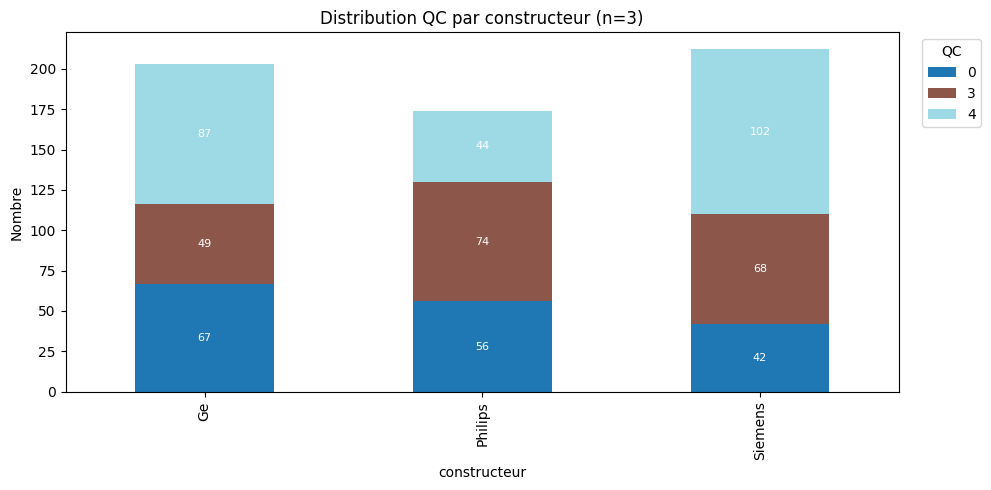


=== Statistiques QC par 'modèle' ===

Counts (extrait):


__QC_clean,0,3,4
modèle,,,
Achieva,37,35,26
Discovery,39,38,48
Ingenia,19,39,18
Prisma,1,5,6
Signa,28,11,39
Skyra,36,50,70
Verio,5,13,26



Percentages (% par ligne, extrait):


__QC_clean,0,3,4
modèle,,,
Achieva,37.8,35.7,26.5
Discovery,31.2,30.4,38.4
Ingenia,25.0,51.3,23.7
Prisma,8.3,41.7,50.0
Signa,35.9,14.1,50.0
Skyra,23.1,32.1,44.9
Verio,11.4,29.5,59.1



% de QC == 0 par groupe:


modèle
Achieva      37.8
Signa        35.9
Discovery    31.2
Ingenia      25.0
Skyra        23.1
Verio        11.4
Prisma        8.3
dtype: float64

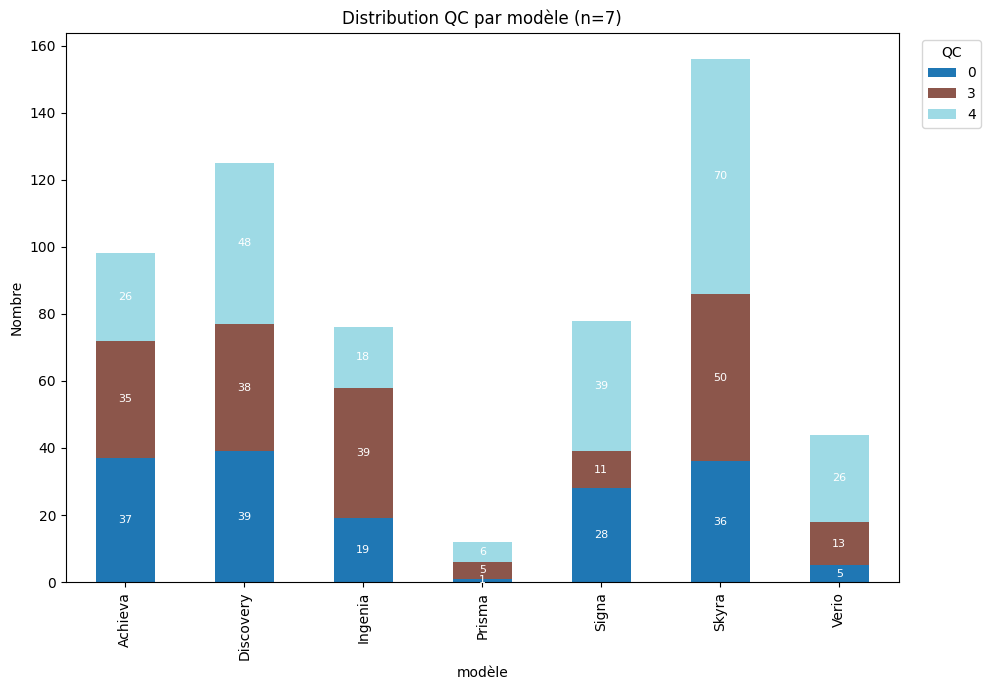


=== Statistiques QC par 'champ' ===

Counts (extrait):


__QC_clean,0,3,4
champ,,,
3T,165,191,233



Percentages (% par ligne, extrait):


__QC_clean,0,3,4
champ,,,
3T,28.0,32.4,39.6



% de QC == 0 par groupe:


champ
3T    28.0
dtype: float64

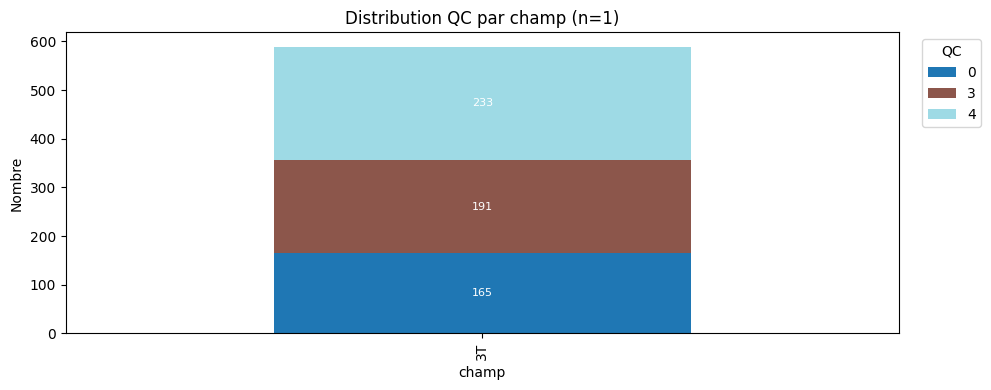


=== Statistiques QC par 'Centre' ===

Counts (extrait):


__QC_clean,0,3,4
Centre,,,
Amiens,0,1,4
Bordeaux,6,5,7
Clermont ferrand,13,8,14
Lille,25,15,13
Lyon,17,33,17
Lyon Sud,2,4,2
Marseille,18,29,42
Nancy,3,5,11
Nice,8,9,7



Percentages (% par ligne, extrait):


__QC_clean,0,3,4
Centre,,,
Amiens,0.0,20.0,80.0
Bordeaux,33.3,27.8,38.9
Clermont ferrand,37.1,22.9,40.0
Lille,47.2,28.3,24.5
Lyon,25.4,49.3,25.4
Lyon Sud,25.0,50.0,25.0
Marseille,20.2,32.6,47.2
Nancy,15.8,26.3,57.9
Nice,33.3,37.5,29.2



% de QC == 0 par groupe:


Centre
Lille                47.2
Paris                37.5
Clermont ferrand     37.1
Bordeaux             33.3
Nice                 33.3
Rouen                31.0
Rothschild           27.7
Lyon                 25.4
Lyon Sud             25.0
Poitiers             22.9
Marseille            20.2
Nancy                15.8
Rennes               12.5
Amiens                0.0
dtype: float64

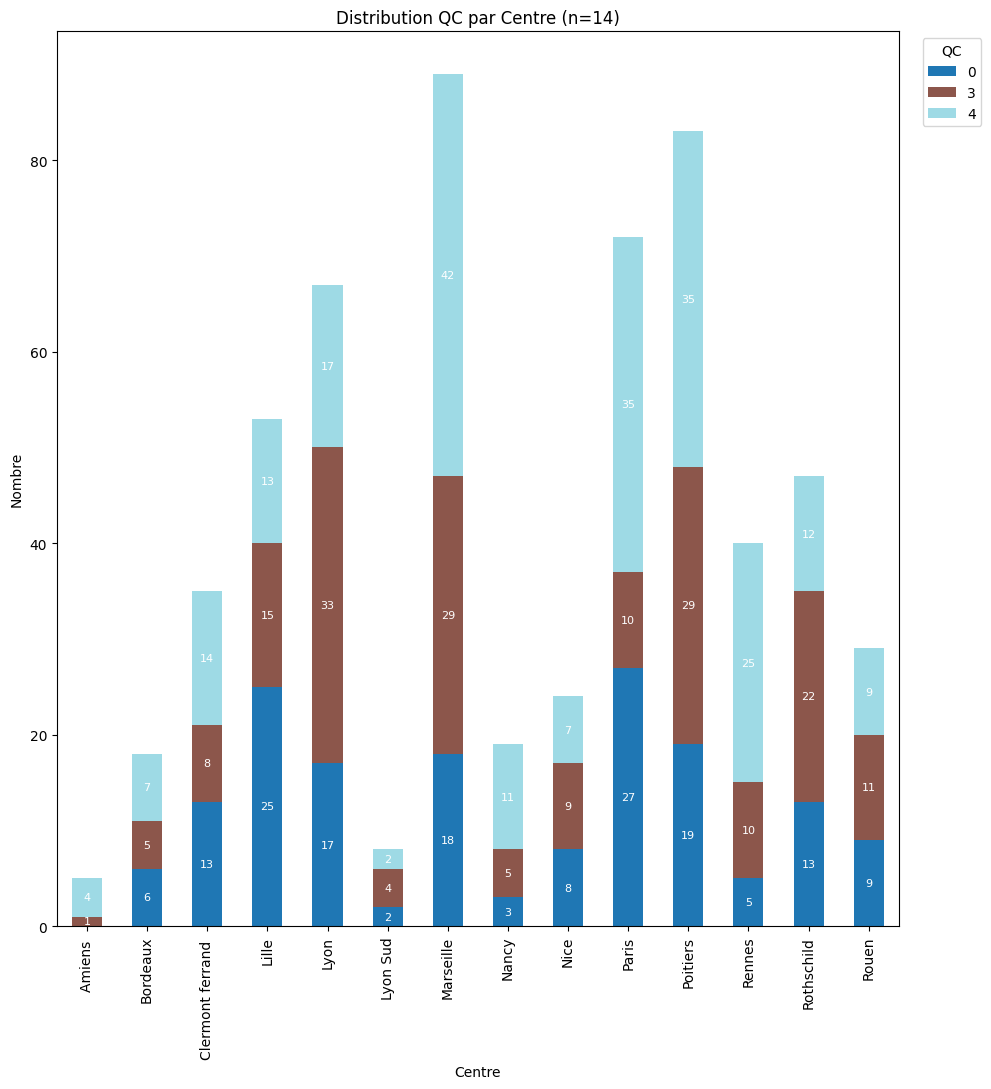

In [21]:
# stats_QC_by_device_model_field.py

# utilise le DataFrame `df` déjà présent dans le notebook
# calcule et affiche des tableaux et graphiques de QC_FINAL_3DMULTI
# groupés par 'constructeur', 'modèle' et 'champ'

def _prepare_qc_series(df, col_qc="QC_FINAL_3DMULTI"):
    # filtrer NaN et valeurs "NF" (insensible à la casse) puis convertir en entier si possible
    s = df[col_qc].astype(object)
    mask = s.notna() & (s.astype(str).str.upper() != "NF")
    s = s[mask]
    s = pd.to_numeric(s, errors="coerce").dropna().astype(int)
    return df.loc[s.index].assign(__QC_clean=s)

def show_qc_stats_by(df, group_col, col_qc="__QC_clean", max_rows_plot=20):
    print(f"\n=== Statistiques QC par '{group_col}' ===")
    if group_col not in df.columns:
        print(f"Colonne '{group_col}' introuvable.")
        return

    # tableau de contingence (counts) et pourcentages par ligne
    ctab = pd.crosstab(df[group_col].fillna("(NA)"), df[col_qc]).sort_index()
    if ctab.empty:
        print("Aucun QC disponible pour ce regroupement.")
        return
    pct = (ctab.div(ctab.sum(axis=1), axis=0) * 100).round(1)

    # pourcentage de 0 (si présent)
    pct0 = (ctab.get(0, 0) / ctab.sum(axis=1) * 100).round(1)

    # affichage concis
    print("\nCounts (extrait):")
    display(ctab.head(50))
    print("\nPercentages (% par ligne, extrait):")
    display(pct.head(50))
    print("\n% de QC == 0 par groupe:")
    display(pct0.sort_values(ascending=False).head(50))

    # graphique empilé — limiter le nombre de groupes affichés pour lisibilité
    n_groups = len(ctab)
    to_plot = ctab
    title = f"Distribution QC par {group_col} (n={n_groups})"
    if n_groups > max_rows_plot:
        # garder les plus grosses catégories (par total) et regrouper le reste
        totals = ctab.sum(axis=1).sort_values(ascending=False)
        top_idx = totals.index[:max_rows_plot]
        other_idx = totals.index[max_rows_plot:]
        other = ctab.loc[other_idx].sum(axis=0).to_frame().T
        other.index = ["(autres)"]
        to_plot = pd.concat([ctab.loc[top_idx], other], axis=0)

    ax_local = to_plot.plot(kind="bar", stacked=True, figsize=(10, 4 + min(8, n_groups//2)), colormap="tab20")
    ax_local.set_title(title)
    ax_local.set_xlabel(group_col)
    ax_local.set_ylabel("Nombre")
    ax_local.legend(title="QC", bbox_to_anchor=(1.02, 1), loc="upper left")

    # annoter chaque segment si raisonnable
    for i, idx in enumerate(to_plot.index):
        cum = 0
        for val in to_plot.loc[idx]:
            if val > 0:
                ax_local.text(i, cum + val / 2, int(val), ha="center", va="center", color="white", fontsize=8)
                cum += val

    plt.tight_layout()
    plt.show()

# préparation des données QC propres
df_qc = _prepare_qc_series(df, "QC_FINAL_3DMULTI")

# colonnes demandées
for colname in ["constructeur", "modèle", "champ","Centre"]:
    show_qc_stats_by(df_qc, colname)


Lecture de FAIRPARKII_resT2_W00.xlsx avec 148 lignes. study = /NAS/dumbo/protocoles/FAIRPARKII/FAIRPARKII_resT2_W00.xlsx
FAIRPARKII_resT2_W00.xlsx -> RN_L=RN_L, RN_R=RN_R, SN_L=SN_L, SN_R=SN_R,GPI_L=GPi_L, GPI_R=GPi_R, GPE_L=GPe_L, GPE_R=GPe_R,CAUDATE_L=Left_caudate, CAUDATE_R=Right_caudate
Lecture de FAIRPARKII_resT2_W36.xlsx avec 148 lignes. study = /NAS/dumbo/protocoles/FAIRPARKII/FAIRPARKII_resT2_W36.xlsx
FAIRPARKII_resT2_W36.xlsx -> RN_L=RN_L, RN_R=RN_R, SN_L=SN_L, SN_R=SN_R,GPI_L=GPi_L, GPI_R=GPi_R, GPE_L=GPe_L, GPE_R=GPe_R,CAUDATE_L=Left_caudate, CAUDATE_R=Right_caudate
Lecture de valeurs_sous_corticales_keuken_Volbrain.xlsx avec 181 lignes. study = PULSE
valeurs_sous_corticales_keuken_Volbrain.xlsx -> RN_L=Moyenne Noyau rouge gauche, RN_R=None, SN_L=Moyenne Substance noire gauche, SN_R=Moyenne Substance noire droite,GPI_L=Moyenne Globus Pallidus interne gauche, GPI_R=None, GPE_L=Moyenne Globus Pallidus externe gauche, GPE_R=None,CAUDATE_L=None, CAUDATE_R=None
Lecture de 2025041

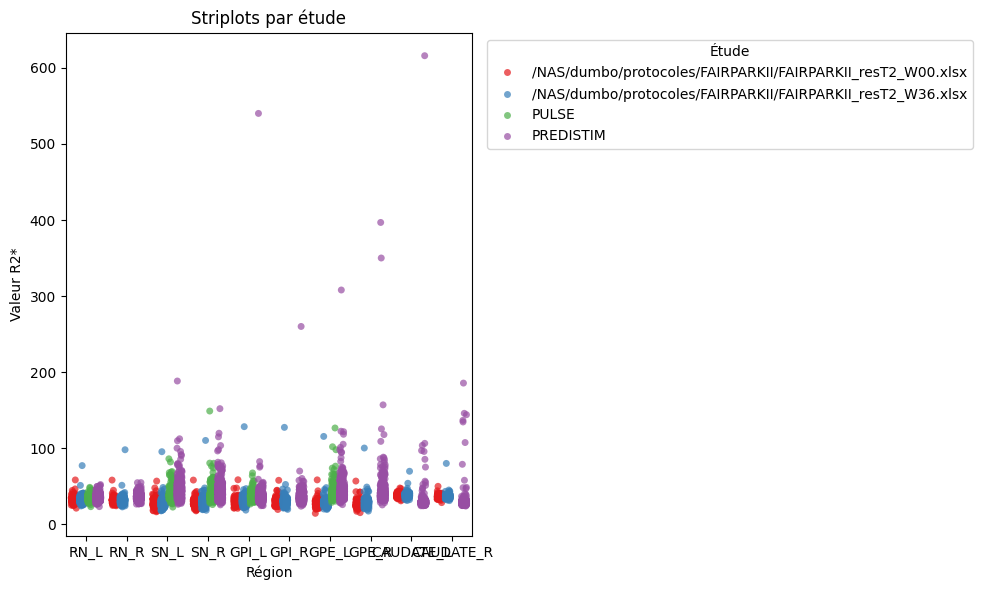

Fichier: FAIRPARKII_resT2_W00.xlsx
  Feuille: 'W00' — lignes: 148 — colonnes (20): ['SUBJ', 'GROUPE', 'RN_L', 'RN_R', 'GPi_L', 'GPi_R', 'GPe_L', 'GPe_R', 'SN_L', 'SN_R', 'Left_putamen', 'Right_putamen', 'Left_caudate', 'Right_caudate', 'Left_globus_pallidus', 'Right_globus_pallidus', 'Left_thalamus', 'Right_thalamus', 'STh_L', 'STh_R']

Fichier: FAIRPARKII_resT2_W36.xlsx
  Feuille: 'W36' — lignes: 148 — colonnes (20): ['SUBJ', 'GROUPE', 'RN_L', 'RN_R', 'GPi_L', 'GPi_R', 'GPe_L', 'GPe_R', 'SN_L', 'SN_R', 'Left_putamen', 'Right_putamen', 'Left_caudate', 'Right_caudate', 'Left_globus_pallidus', 'Right_globus_pallidus', 'Left_thalamus', 'Right_thalamus', 'STh_L', 'STh_R']

Fichier: valeurs_sous_corticales_keuken_Volbrain.xlsx
  Feuille: 'Sheet1' — lignes: 181 — colonnes (50): ['Unnamed: 0', 'SUBJID', 'Moyenne Noyau rouge gauche', 'Mediane Noyau rouge gauche', 'Moyenne Substance noire gauche', 'Mediane Substance noire gauche', 'Moyenne Globus Pallidus externe gauche', 'Mediane Globus Pallid

In [111]:
import seaborn as sns
import re


paths = [
    #Path("/NAS/dumbo/protocoles/FAIRPARKII/VolumeAndR2_ANX_NoANx.xlsx"),#RN_L	RN_R    SN_L	SN_R
    Path("/NAS/dumbo/protocoles/FAIRPARKII/FAIRPARKII_resT2_W00.xlsx"),#RN_L	RN_R    SN_L	SN_R
    Path("/NAS/dumbo/protocoles/FAIRPARKII/FAIRPARKII_resT2_W36.xlsx"),#
    #Path("/NAS/tupac/protocoles/PULSE/valeurs_corticales_glasser360.xlsx"),
    Path("/NAS/tupac/protocoles/PULSE/valeurs_sous_corticales_keuken_Volbrain.xlsx"),#Moyenne Noyau rouge gauche	Moyenne Substance noire gauche
    #Path("/NAS/tupac/protocoles/PULSE/valeurs_sous_corticales_Volbrain.xlsx"), 
    Path("/NAS/deathrow/protocoles/predistim/csv_xlsx/20250417_R2_moyens.xlsx"), #R2_mean_FLASH_RN_L	R2_mean_FLASH_RN_R	R2_mean_FLASH_SN_L	R2_mean_FLASH_SN_R
    Path("'/NAS/dumbo/protocoles/GAITnPARK/csv_xls_etc/Stat_these_MRIdata_W00.xlsx'"),
    Path("'/NAS/dumbo/protocoles/GAITnPARK/csv_xls_etc/Stat_these_MRIdata_W24.xlsx'"),
    Path("'/NAS/dumbo/protocoles/GAITnPARK/csv_xls_etc/Stat_these_MRIdata_W48.xlsx'"),

]


def short_study_name(stem: str) -> str:
    s = stem.lower()
    if "FAIRPARKII" in s and "W00" in s:
        return "FairPARKII_W00"
    if "FAIRPARKII" in s and "W36" in s:
        return "FairPARKII_W36"
    if "pulse" in s:
        return "PULSE"
    if "predistim" in s or "pred" in s:
        return "PREDISTIM"
    if "GAITnPARK" in s and "W00" in s:
        return "GAITnPARK_W00"
    if "GAITnPARK" in s and "W24" in s:
        return "GAITnPARK_W24"
    if "GAITnPARK" in s and "W48" in s:
        return "GAITnPARK_W48"
    return stem


def _find_lr_column(cols, keywords, side_tokens_left=("L","gauche", "GAUCHE", "_L", " LEFT"),
                            side_tokens_right=("R","droite", "DROITE", "_R", " RIGHT")):
    cols_up = [c for c in cols if isinstance(c, str)]
    left = None
    right = None
    keywords_up = [k.upper() for k in keywords]
    # candidates that mention the keyword (RN or SN) anywhere
    candidates = [c for c in cols_up if any(kw in c.upper() for kw in keywords_up)]

    for c in candidates:
        cu = c.upper()
        # stronger, bounded checks first to avoid matching letters inside words like "TOTAL"
        if left is None and (cu.endswith('_L') or cu.endswith(' L') or ' GAUCHE' in cu or ' LEFT' in cu or re.search(r'\bL\b', cu)):
            left = c
        if right is None and (cu.endswith('_R') or cu.endswith(' R') or ' DROITE' in cu or ' RIGHT' in cu or re.search(r'\bR\b', cu)):
            right = c
        if left is not None and right is not None:
            break

    # fallback: if exactly two candidates, assume first = left, second = right
    if left is None and right is None and len(candidates) == 2:
        left, right = candidates[0], candidates[1]
    # final fallback: try any column that contains the keyword (even without L/R)
    if left is None and candidates:
        left = candidates[0]
    return left, right

results = []
for p in paths:
    if not p.exists():
        print(f"Fichier introuvable, saut: {p.name}")
        continue
    sheets = pd.read_excel(p, sheet_name=None)
    df_local = next(iter(sheets.values()))
    

    study = short_study_name(str(p))
    print(f"Lecture de {p.name} avec {len(df_local)} lignes. study = {study}")
    
    cols = list(df_local.columns)

    # try multiple heuristics for RN / SN column names
    rn_left, rn_right = _find_lr_column(cols, keywords=("RN", "NOYAU ROUGE", "ROUGE"))
    sn_left, sn_right = _find_lr_column(cols, keywords=("SN", "SUBSTANCE NOIRE", "NOIRE", "SUBSTANCE"))
    gpi_left, gpi_right = _find_lr_column(cols, keywords=("GPI",  "GLOBUS PALLIDUS INTERNE"))
    gpe_left, gpe_right = _find_lr_column(cols, keywords=("GPE", "GLOBUS PALLIDUS EXTERNE"))
    caudate_left, caudate_right = _find_lr_column(cols, keywords=("CAUDATE", "NUCLEUS CAUDATUS"))

    # # specific common patterns (for PREDISTIM in your notebook)
    # if rn_left is None:
    #     for pat in ("R2_mean_FLASH_RN_L", "R2_mean_FLASH_RN_L".upper()):
    #         if pat in [c.upper() for c in cols]:
    #             rn_left = next(c for c in cols if c.upper() == pat)
    # if rn_right is None:
    #     for pat in ("R2_mean_FLASH_RN_R",):
    #         if pat in [c.upper() for c in cols]:
    #             rn_right = next(c for c in cols if c.upper() == pat)
    # if sn_left is None:
    #     for pat in ("R2_mean_FLASH_SN_L",):
    #         if pat in [c.upper() for c in cols]:
    #             sn_left = next(c for c in cols if c.upper() == pat)
    # if sn_right is None:
    #     for pat in ("R2_mean_FLASH_SN_R",):
    #         if pat in [c.upper() for c in cols]:
    #             sn_right = next(c for c in cols if c.upper() == pat)

    # report what was found
    print(f"{p.name} -> RN_L={rn_left}, RN_R={rn_right}, SN_L={sn_left}, SN_R={sn_right},GPI_L={gpi_left}, GPI_R={gpi_right}, GPE_L={gpe_left}, GPE_R={gpe_right},CAUDATE_L={caudate_left}, CAUDATE_R={caudate_right}")

    # build a small standardized dataframe if we have at least some columns
    std = {}
    if rn_left in df_local.columns:
        std["RN_L"] = pd.to_numeric(df_local[rn_left], errors="coerce")
    if rn_right in df_local.columns:
        std["RN_R"] = pd.to_numeric(df_local[rn_right], errors="coerce")
    if sn_left in df_local.columns:
        std["SN_L"] = pd.to_numeric(df_local[sn_left], errors="coerce")
    if sn_right in df_local.columns:
        std["SN_R"] = pd.to_numeric(df_local[sn_right], errors="coerce")
    if gpi_left in df_local.columns:
        std["GPI_L"] = pd.to_numeric(df_local[gpi_left], errors="coerce")
    if gpi_right in df_local.columns:
        std["GPI_R"] = pd.to_numeric(df_local[gpi_right], errors="coerce")
    if gpe_left in df_local.columns:
        std["GPE_L"] = pd.to_numeric(df_local[gpe_left], errors="coerce")
    if gpe_right in df_local.columns:
        std["GPE_R"] = pd.to_numeric(df_local[gpe_right], errors="coerce")        
    if caudate_left in df_local.columns:
        std["CAUDATE_L"] = pd.to_numeric(df_local[caudate_left], errors="coerce")
    if caudate_right in df_local.columns:
        std["CAUDATE_R"] = pd.to_numeric(df_local[caudate_right], errors="coerce")
    if not std:
        print(f"  -> aucune colonne RN/SN trouvée dans {p.name}, saut\n")
        continue

    tmp = pd.DataFrame(std)
    tmp["study"] = study
    results.append(tmp)

if not results:
    print("Aucune donnée RN/SN agrégée — rien à tracer.")
else:
    combined = pd.concat(results, ignore_index=True)
    # melt to long format for seaborn
    long = combined.melt(id_vars="study", value_vars=["RN_L","RN_R","SN_L","SN_R","GPI_L","GPI_R","GPE_L","GPE_R","CAUDATE_L","CAUDATE_R"],
                         var_name="region", value_name="value").dropna()

    plt.figure(figsize=(10,6))
    sns.stripplot(data=long, x="region", y="value", hue="study",
                  dodge=True, jitter=0.25, alpha=0.7, palette="Set1")
    plt.title("Striplots par étude")
    plt.xlabel("Région")
    
    plt.ylabel("Valeur R2*")
    plt.legend(title="Étude", bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

for p in paths:
    print(f"Fichier: {p.name}")
    if not p.exists():
        print("  -> introuvable, saut\n")
        continue

    try:
        sheets = pd.read_excel(p, sheet_name=None, engine="openpyxl")
    except Exception as e:
        print(f"  -> erreur à la lecture: {e}\n")
        continue

    total_rows = 0
    for sheet_name, df_local in sheets.items():
        total_rows += len(df_local)
        cols = [c.strip() if isinstance(c, str) else c for c in df_local.columns]
        print(f"  Feuille: '{sheet_name}' — lignes: {len(df_local)} — colonnes ({len(cols)}): {cols}")
    if len(sheets) > 1:
        print(f"  Lignes totales (somme des feuilles): {total_rows}")
    print()


In [107]:

paths = [
    #Path("/NAS/dumbo/protocoles/FAIRPARKII/VolumeAndR2_ANX_NoANx.xlsx"),#RN_L	RN_R    SN_L	SN_R
    Path("/NAS/dumbo/protocoles/FAIRPARKII/FAIRPARKII_resT2_W00.xlsx"),#RN_L	RN_R    SN_L	SN_R
    Path("/NAS/dumbo/protocoles/FAIRPARKII/FAIRPARKII_resT2_W36.xlsx"),#
    #Path("/NAS/tupac/protocoles/PULSE/valeurs_corticales_glasser360.xlsx"),
    Path("/NAS/tupac/protocoles/PULSE/valeurs_sous_corticales_keuken_Volbrain.xlsx"),#Moyenne Noyau rouge gauche	Moyenne Substance noire gauche
    #Path("/NAS/tupac/protocoles/PULSE/valeurs_sous_corticales_Volbrain.xlsx"), 
    Path("/NAS/deathrow/protocoles/predistim/csv_xlsx/20250417_R2_moyens.xlsx"), #R2_mean_FLASH_RN_L	R2_mean_FLASH_RN_R	R2_mean_FLASH_SN_L	R2_mean_FLASH_SN_R
    Path("'/NAS/dumbo/protocoles/GAITnPARK/csv_xls_etc/Stat_these_MRIdata_W00.xls'"),
    Path("'/NAS/dumbo/protocoles/GAITnPARK/csv_xls_etc/Stat_these_MRIdata_W24.xls'"),
    Path("'/NAS/dumbo/protocoles/GAITnPARK/csv_xls_etc/Stat_these_MRIdata_W48.xls'"),

]

def short_study_name(stem: str) -> str:
    s = stem.lower()
    if "FAIRPARKII" in s and "W00" in s:
        return "FairPARKII_W00"
    if "FAIRPARKII" in s and "W36" in s:
        return "FairPARKII_W36"
    if "pulse" in s:
        return "PULSE"
    if "predistim" in s or "pred" in s:
        return "PREDISTIM"
    if "GAITnPARK" in s and "W00" in s:
        return "GAITnPARK_W00"
    if "GAITnPARK" in s and "W24" in s:
        return "GAITnPARK_W24"
    if "GAITnPARK" in s and "W48" in s:
        return "GAITnPARK_W48"
    return stem

def _find_lr_column(cols, keywords, side_tokens_left=("L","gauche", "GAUCHE", "_L", " LEFT"),
                            side_tokens_right=("R","droit", "DROITE", "_R", " RIGHT")):
    cols_up = [c for c in cols if isinstance(c, str)]
    left = None
    right = None
    keywords_up = [k.upper() for k in keywords]
    # candidates that mention the keyword (RN or SN) anywhere
    candidates = [c for c in cols_up if any(kw in c.upper() for kw in keywords_up)]
    print(f" candidates : {candidates}")
    for c in candidates:
        cu = c.upper()
        # stronger, bounded checks first to avoid matching letters inside words like "TOTAL"
        if left is None and (cu.endswith('_L') or cu.endswith(' L') or ' GAUCHE' in cu or ' LEFT' in cu or re.search(r'\bL\b', cu)):
            left = c
        if right is None and (cu.endswith('_R') or cu.endswith(' R') or ' DROITE' in cu or ' RIGHT' in cu or re.search(r'\bR\b', cu)):
            right = c
        if left is not None and right is not None:
            print(f" left: {left}, right: {right} after checking {c}")
            break

    return left, right

results = []

for p in paths:
    if not p.exists():
        print(f"Fichier introuvable, saut: {p.name}")
        continue
    sheets = pd.read_excel(p, sheet_name=None)
    df_local = next(iter(sheets.values()))
    

    study = short_study_name(str(p))
    print(f"Lecture de {p.name} avec {len(df_local)} lignes. study = {study}")
    
    cols = list(df_local.columns)

    # try multiple heuristics for RN / SN column names
    rn_left, rn_right = _find_lr_column(cols, keywords=("RN", "NOYAU ROUGE", "ROUGE"))
    sn_left, sn_right = _find_lr_column(cols, keywords=("SN", "SUBSTANCE NOIRE", "NOIRE", "SUBSTANCE"))
    gpi_left, gpi_right = _find_lr_column(cols, keywords=("GPI",  "GLOBUS PALLIDUS INTERNE"))
    gpe_left, gpe_right = _find_lr_column(cols, keywords=("GPE", "GLOBUS PALLIDUS EXTERNE"))
    caudate_left, caudate_right = _find_lr_column(cols, keywords=("caudé","CAUDATE", "NUCLEUS CAUDATUS"))

    print(f"***********{p.name}**********")
    print(f" RN_L={rn_left}, RN_R={rn_right}")
    print(f" SN_L={sn_left}, SN_R={sn_right} ")
    print(f"GPI_L={gpi_left}, GPI_R={gpi_right}, GPE_L={gpe_left}, GPE_R={gpe_right}")
    print(f"CAUDATE_L={caudate_left}, CAUDATE_R={caudate_right}")
    print(f"GPI_R={gpi_right}, GPE_L={gpe_left}, GPE_R={gpe_right},CAUDATE_L={caudate_left}, CAUDATE_R={caudate_right}")


Lecture de FAIRPARKII_resT2_W00.xlsx avec 148 lignes. study = /NAS/dumbo/protocoles/FAIRPARKII/FAIRPARKII_resT2_W00.xlsx
 candidates : ['RN_L', 'RN_R']
 left: RN_L, right: RN_R after checking RN_R
 candidates : ['SN_L', 'SN_R']
 left: SN_L, right: SN_R after checking SN_R
 candidates : ['GPi_L', 'GPi_R']
 left: GPi_L, right: GPi_R after checking GPi_R
 candidates : ['GPe_L', 'GPe_R']
 left: GPe_L, right: GPe_R after checking GPe_R
 candidates : ['Left_caudate', 'Right_caudate']
***********FAIRPARKII_resT2_W00.xlsx**********
 RN_L=RN_L, RN_R=RN_R
 SN_L=SN_L, SN_R=SN_R 
GPI_L=GPi_L, GPI_R=GPi_R, GPE_L=GPe_L, GPE_R=GPe_R
CAUDATE_L=None, CAUDATE_R=None
GPI_R=GPi_R, GPE_L=GPe_L, GPE_R=GPe_R,CAUDATE_L=None, CAUDATE_R=None
Lecture de FAIRPARKII_resT2_W36.xlsx avec 148 lignes. study = /NAS/dumbo/protocoles/FAIRPARKII/FAIRPARKII_resT2_W36.xlsx
 candidates : ['RN_L', 'RN_R']
 left: RN_L, right: RN_R after checking RN_R
 candidates : ['SN_L', 'SN_R']
 left: SN_L, right: SN_R after checking SN_R
 

In [108]:
# tableau statique étude x structure (remplace la construction dynamique)
df_colname_map = pd.DataFrame({
    "FairPARKII_W00": {
        "RN_L": "RN_L", "RN_R": "RN_R",
        "SN_L": "SN_L", "SN_R": "SN_R",
        "GPI_L": "GPi_L", "GPI_R": "GPi_R",
        "GPE_L": "GPe_L", "GPE_R": "GPe_R",
        "CAUDATE_L": "Left_caudate", "CAUDATE_R": "Right_caudate",
        "Thalamus_L": "Left_thalamus", "Thalamus_R": "Right_thalamus",
        "Putamen_L": "Left_putamen", "Putamen_R": "Right_putamen",
        "STh_L": "STh_L", "STh_R": "STh_R"
    },
    "FairPARKII_W36": {
        "RN_L": "RN_L", "RN_R": "RN_R",
        "SN_L": "SN_L", "SN_R": "SN_R",
        "GPI_L": "GPi_L", "GPI_R": "GPi_R",
        "GPE_L": "GPe_L", "GPE_R": "GPe_R",
        "CAUDATE_L": "Left_caudate", "CAUDATE_R": "Right_caudate",
        "Thalamus_L": "Left_thalamus", "Thalamus_R": "Right_thalamus",
        "Putamen_L": "Left_putamen", "Putamen_R": "Right_putamen",
        "STh_L": "STh_L", "STh_R": "STh_R"
    },
    "PULSE": {
        "RN_L": "Moyenne Noyau rouge gauche", "RN_R": "Moyenne Noyau rouge droit",
        "SN_L": "Moyenne Substance noire gauche", "SN_R": "Moyenne Substance noire droite",
        "GPI_L": "Moyenne Globus Pallidus interne gauche", "GPI_R": "Moyenne Globus Pallidus interne gauche",
        "GPE_L": "Moyenne Globus Pallidus externe gauche", "GPE_R": "Moyenne Globus Pallidus externe droit",
        "CAUDATE_L": "Moyenne Tête du noyau caudé gauche", "CAUDATE_R": "Moyenne Tête du noyau caudé droit",
        "Thalamus_L": "Moyenne Thalamus gauche", "Thalamus_R": "Moyenne Thalamus droit",
        "Putamen_L": "Moyenne Putamen gauche", "Putamen_R": "Moyenne Putamen droit"
    },
    "PREDISTIM": {
        "RN_L": "R2_mean_FLASH_RN_L", "RN_R": "R2_mean_FLASH_RN_R",
        "SN_L": "R2_mean_FLASH_SN_L", "SN_R": "R2_mean_FLASH_SN_R",
        "GPI_L": "R2_mean_QSM_GPi_L", "GPI_R": "R2_mean_QSM_GPi_R",
        "GPE_L": "R2_mean_QSM_GPe_L", "GPE_R": "R2_mean_QSM_GPe_R",
        "CAUDATE_L": "R2_mean_Caudate_L", "CAUDATE_R": "R2_mean_Caudate_R",
        "Thalamus_L": "R2_mean_Thalamus_L", "Thalamus_R": "R2_mean_Thalamus_R",
        "Putamen_L": "R2_mean_Putamen_L", "Putamen_R": "R2_mean_Putamen_R",
        "STh_L": "R2_mean_FLASH_STh_L", "STh_R": "R2_mean_FLASH_STh_R"
    },
    "GAITnPARK_W00": {
        "RN_L": "R2_RN_L", "RN_R": "R2_RN_R",
        "SN_L": "R2_SN_L", "SN_R": "R2_SN_R",
        "GPI_L": "R2_Gpi_L", "GPI_R": "R2_Gpi_R",
        "GPE_L": "R2_Gpe_L", "GPE_R": "R2_Gpe_R",
        "CAUDATE_L": "R2_caudate_L", "CAUDATE_R": "R2_caudate_R",
        "Thalamus_L": "R2_thalamus_L", "Thalamus_R": "R2_thalamus_R",
        "Putamen_L": "R2_putamen_L", "Putamen_R": "R2_putamen_R",
        "STh_L": "R2_NST_L", "STh_R": "R2_NST_R"
    },
    "GAITnPARK_W24": {
        "RN_L": "R2_RN_L", "RN_R": "R2_RN_R",
        "SN_L": "R2_SN_L", "SN_R": "R2_SN_R",
        "GPI_L": "R2_Gpi_L", "GPI_R": "R2_Gpi_R",
        "GPE_L": "R2_Gpe_L", "GPE_R": "R2_Gpe_R",
        "CAUDATE_L": "R2_caudate_L", "CAUDATE_R": "R2_caudate_R",
        "Thalamus_L": "R2_thalamus_L", "Thalamus_R": "R2_thalamus_R",
        "Putamen_L": "R2_putamen_L", "Putamen_R": "R2_putamen_R",
        "STh_L": "R2_NST_L", "STh_R": "R2_NST_R"
    },
    "GAITnPARK_W48": {
        "RN_L": "R2_RN_L", "RN_R": "R2_RN_R",
        "SN_L": "R2_SN_L", "SN_R": "R2_SN_R",
        "GPI_L": "R2_Gpi_L", "GPI_R": "R2_Gpi_R",
        "GPE_L": "R2_Gpe_L", "GPE_R": "R2_Gpe_R",
        "CAUDATE_L": "R2_caudate_L", "CAUDATE_R": "R2_caudate_R",
        "Thalamus_L": "R2_thalamus_L", "Thalamus_R": "R2_thalamus_R",
        "Putamen_L": "R2_putamen_L", "Putamen_R": "R2_putamen_R",
        "STh_L": "R2_NST_L", "STh_R": "R2_NST_R"
    },
}).T.sort_index()

print("Table étude x structure -> nom de colonne source (statique) :")
display(df_colname_map)


Table étude x structure -> nom de colonne source (statique) :


,RN_L,RN_R,SN_L,SN_R,GPI_L,GPI_R,GPE_L,GPE_R,CAUDATE_L,CAUDATE_R,Thalamus_L,Thalamus_R,Putamen_L,Putamen_R,STh_L,STh_R
FairPARKII_W00,RN_L,RN_R,SN_L,SN_R,GPi_L,GPi_R,GPe_L,GPe_R,Left_caudate,Right_caudate,Left_thalamus,Right_thalamus,Left_putamen,Right_putamen,STh_L,STh_R
FairPARKII_W36,RN_L,RN_R,SN_L,SN_R,GPi_L,GPi_R,GPe_L,GPe_R,Left_caudate,Right_caudate,Left_thalamus,Right_thalamus,Left_putamen,Right_putamen,STh_L,STh_R
GAITnPARK_W00,R2_RN_L,R2_RN_R,R2_SN_L,R2_SN_R,R2_Gpi_L,R2_Gpi_R,R2_Gpe_L,R2_Gpe_R,R2_caudate_L,R2_caudate_R,R2_thalamus_L,R2_thalamus_R,R2_putamen_L,R2_putamen_R,R2_NST_L,R2_NST_R
GAITnPARK_W24,R2_RN_L,R2_RN_R,R2_SN_L,R2_SN_R,R2_Gpi_L,R2_Gpi_R,R2_Gpe_L,R2_Gpe_R,R2_caudate_L,R2_caudate_R,R2_thalamus_L,R2_thalamus_R,R2_putamen_L,R2_putamen_R,R2_NST_L,R2_NST_R
GAITnPARK_W48,R2_RN_L,R2_RN_R,R2_SN_L,R2_SN_R,R2_Gpi_L,R2_Gpi_R,R2_Gpe_L,R2_Gpe_R,R2_caudate_L,R2_caudate_R,R2_thalamus_L,R2_thalamus_R,R2_putamen_L,R2_putamen_R,R2_NST_L,R2_NST_R
PREDISTIM,R2_mean_FLASH_RN_L,R2_mean_FLASH_RN_R,R2_mean_FLASH_SN_L,R2_mean_FLASH_SN_R,R2_mean_QSM_GPi_L,R2_mean_QSM_GPi_R,R2_mean_QSM_GPe_L,R2_mean_QSM_GPe_R,R2_mean_Caudate_L,R2_mean_Caudate_R,R2_mean_Thalamus_L,R2_mean_Thalamus_R,R2_mean_Putamen_L,R2_mean_Putamen_R,R2_mean_FLASH_STh_L,R2_mean_FLASH_STh_R
PULSE,Moyenne Noyau rouge gauche,Moyenne Noyau rouge droit,Moyenne Substance noire gauche,Moyenne Substance noire droite,Moyenne Globus Pallidus interne gauche,Moyenne Globus Pallidus interne gauche,Moyenne Globus Pallidus externe gauche,Moyenne Globus Pallidus externe droit,Moyenne Tête du noyau caudé gauche,Moyenne Tête du noyau caudé droit,Moyenne Thalamus gauche,Moyenne Thalamus droit,Moyenne Putamen gauche,Moyenne Putamen droit,NaN,NaN


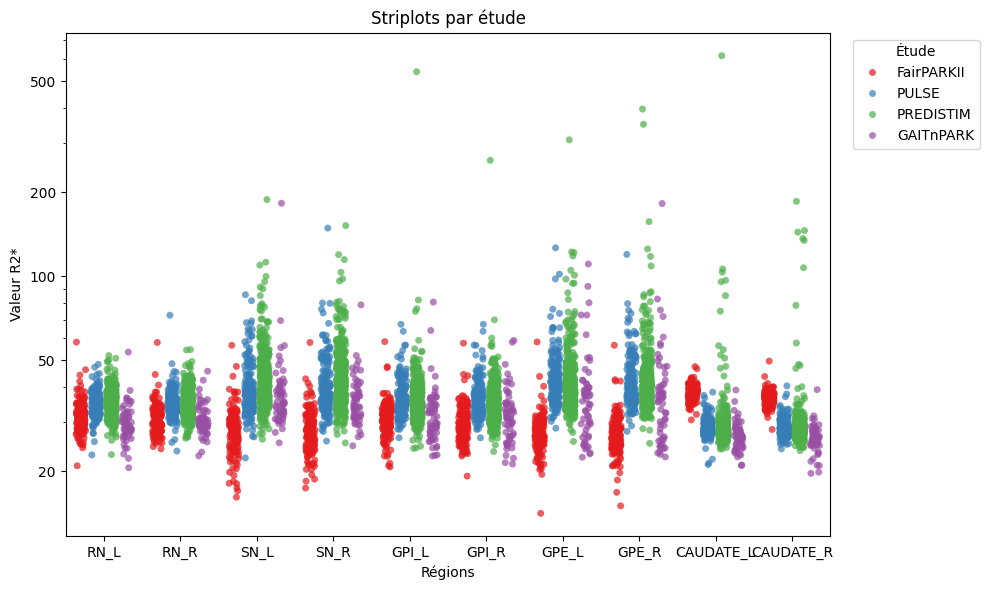

In [103]:
# plot aggregated results (reprise du code demandé, en utilisant `results` / `combined`)
try:
    combined  # existe si la cellule précédente a déjà créé combined
except NameError:
    if not results:
        print("Aucune donnée agrégée — rien à tracer.")
        combined = None
    else:
        combined = pd.concat(results, ignore_index=True)

if combined is None or combined.empty:
    print("combined vide — rien à tracer.")
else:
    # utiliser region_keys s'il est défini, sinon fallback explicite
    try:
        cols_to_melt = region_keys
    except NameError:
        cols_to_melt = ["RN_L","RN_R","SN_L","SN_R","GPI_L","GPI_R","GPE_L","GPE_R","CAUDATE_L","CAUDATE_R"]

    long = combined.melt(
        id_vars="study",
        value_vars=cols_to_melt,
        var_name="region",
        value_name="value"
    ).dropna()

    plt.figure(figsize=(10, 6))
    sns.stripplot(
        data=long, x="region", y="value", hue="study",
        dodge=True, jitter=0.25, alpha=0.7, palette="Set1"
    )
    plt.title("Striplots par étude")
    plt.xlabel("Régions")
    plt.ylabel("Valeur R2*")
    import matplotlib.ticker as mticker

    ax = plt.gca()
    ax.set_yscale("log")

    # major ticks at decades with intermediate 2x and 5x ticks for more labels
    ax.yaxis.set_major_locator(mticker.LogLocator(base=10.0, subs=[1.0, 2.0, 5.0], numticks=15))
    ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda y, pos: f"{y:g}"))

    # minor ticks for finer grid (no labels)
    ax.yaxis.set_minor_locator(mticker.LogLocator(base=10.0, subs=[1,2,3,4,5,6,7,8,9], numticks=50))
    ax.yaxis.set_minor_formatter(mticker.NullFormatter())

    # ax.tick_params(axis="y", which="major", length=6)
    # ax.tick_params(axis="y", which="minor", length=3, alpha=0.6)

    # # ensure positive lower limit for log scale
    # ymin = long["value"].min()
    # if ymin is None or ymin <= 0:
    #     ymin = 1e-3
    # plt.ylim(bottom=max(ymin * 0.8, 1e-3))
    plt.legend(title="Étude", bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.tight_layout()
    plt.show()
